<a href="https://colab.research.google.com/github/alyson-mei/ml_stuff/blob/main/practice/time_series_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from IPython.display import clear_output

In [ ]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
series = data['Passengers'].values.astype(np.float32)

print(len(data))
data.head()

144


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


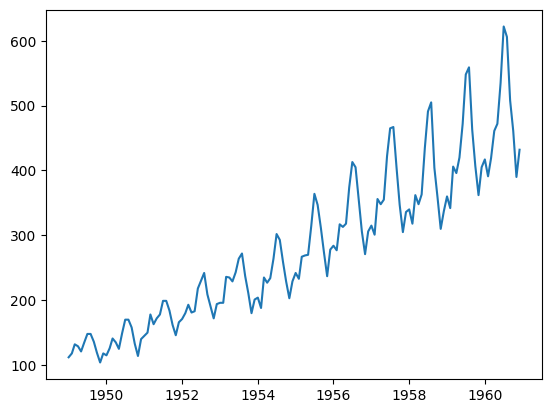

In [ ]:
plt.plot(data['Passengers'])

## Preprocessing (sliding window)

In [ ]:
def create_sequence(data, window_size):
    """
    Creates sequences of the form [a_1, ..., a_n] -> [a_{n + 1}]
    """
    X, y  = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size])
    return torch.FloatTensor(X), torch.FloatTensor(y)

scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1)).flatten()

window_size = 4
X, y = create_sequence(series, window_size)
print(f'{X[:3]}\n{y[:3]}')

tensor([[0.0154, 0.0270, 0.0541, 0.0483],
        [0.0270, 0.0541, 0.0483, 0.0328],
        [0.0541, 0.0483, 0.0328, 0.0598]])
tensor([0.0328, 0.0598, 0.0849])


In [ ]:
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

X_train, y_train = X_train.unsqueeze(-1), y_train.unsqueeze(1)  # [samples, window_size, 1]
X_test, y_test = X_test.unsqueeze(-1), y_test.unsqueeze(1)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([112, 4, 1]) torch.Size([28, 4, 1])
torch.Size([112, 1]) torch.Size([28, 1])


In [ ]:
X_train[:10], y_train[:10]

(tensor([[[0.0154],
          [0.0270],
          [0.0541],
          [0.0483]],
 
         [[0.0270],
          [0.0541],
          [0.0483],
          [0.0328]],
 
         [[0.0541],
          [0.0483],
          [0.0328],
          [0.0598]],
 
         [[0.0483],
          [0.0328],
          [0.0598],
          [0.0849]],
 
         [[0.0328],
          [0.0598],
          [0.0849],
          [0.0849]],
 
         [[0.0598],
          [0.0849],
          [0.0849],
          [0.0618]],
 
         [[0.0849],
          [0.0849],
          [0.0618],
          [0.0290]],
 
         [[0.0849],
          [0.0618],
          [0.0290],
          [0.0000]],
 
         [[0.0618],
          [0.0290],
          [0.0000],
          [0.0270]],
 
         [[0.0290],
          [0.0000],
          [0.0270],
          [0.0212]]]),
 tensor([[0.0328],
         [0.0598],
         [0.0849],
         [0.0849],
         [0.0618],
         [0.0290],
         [0.0000],
         [0.0270],
         [0.0212],

## Model

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 32, output_size = 1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first = True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        X, _ = self.gru(X)
        X = self.linear(X[:, -1, :])
        return X

In [ ]:
model = GRUModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

## Train

Epoch 0: Train Loss: 0.0785, Val Loss: 0.3680
Epoch 100: Train Loss: 0.0101, Val Loss: 0.0353
Epoch 200: Train Loss: 0.0054, Val Loss: 0.0206
Epoch 300: Train Loss: 0.0045, Val Loss: 0.0163
Epoch 400: Train Loss: 0.0038, Val Loss: 0.0130
Epoch 500: Train Loss: 0.0032, Val Loss: 0.0107
Epoch 600: Train Loss: 0.0028, Val Loss: 0.0096
Epoch 700: Train Loss: 0.0026, Val Loss: 0.0089
Epoch 800: Train Loss: 0.0024, Val Loss: 0.0084
Epoch 900: Train Loss: 0.0023, Val Loss: 0.0081


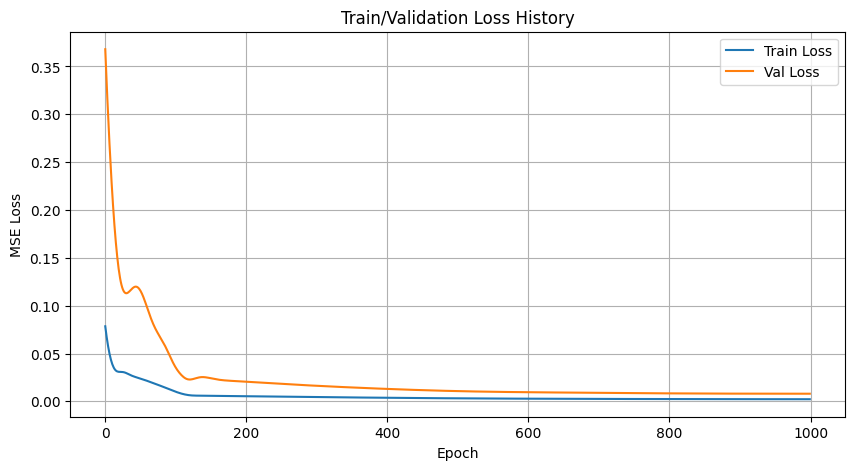

In [ ]:
epochs = 1000
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    train_loss_history.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_output = model(X_test)
        val_loss = criterion(val_output, y_test)
        val_loss_history.append(val_loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label = 'Train Loss')
plt.plot(val_loss_history, label = 'Val Loss')
plt.title('Train/Validation Loss History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid()
plt.show()

## Evaluation

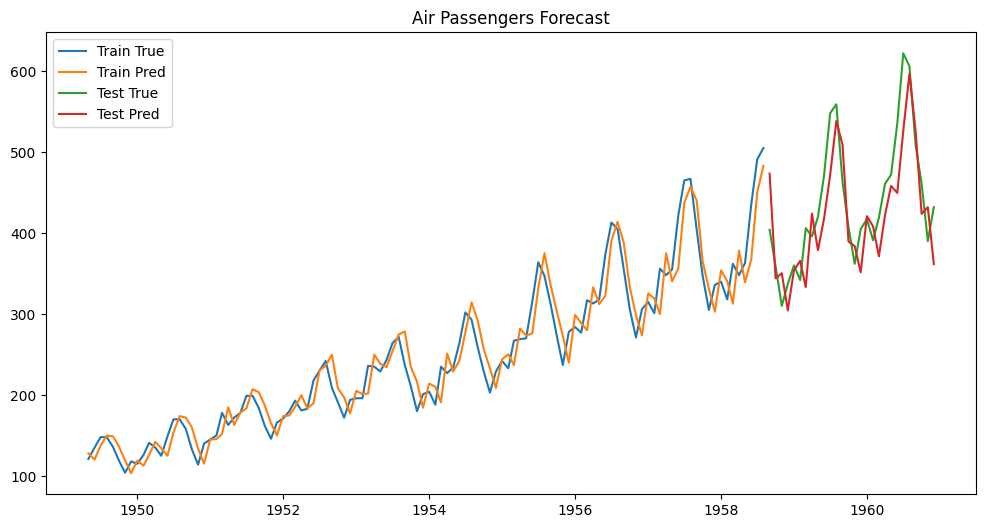

In [ ]:
model.eval()
with torch.no_grad():
    train_pred = model(X_train)
    test_pred = model(X_test)

# inverse scaling
y_train_true = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))
y_test_true = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
train_pred = scaler.inverse_transform(train_pred.numpy().reshape(-1, 1))
test_pred = scaler.inverse_transform(test_pred.numpy().reshape(-1, 1))

plt.figure(figsize=(12, 6))
train_index = data.index[window_size : window_size + len(y_train_true)]
plt.plot(train_index, y_train_true, label='Train True')
plt.plot(train_index, train_pred, label='Train Pred')
test_index = data.index[window_size + len(y_train_true) : window_size + len(y_train_true) + len(y_test_true)]
plt.plot(test_index, y_test_true, label='Test True')
plt.plot(test_index, test_pred, label='Test Pred')

plt.legend()
plt.title('Air Passengers Forecast')
plt.show()